In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

##Import any other packages you may need here
from skimage import io
from pydicom import dcmread
from itertools import chain
from keras.preprocessing.image import ImageDataGenerator
import scipy

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
80193,00019707_012.png,Atelectasis|Effusion|Infiltration|Nodule,12,19707,58,M,AP,2500,2048,0.168,0.168,NaN
28781,00007520_002.png,Atelectasis|Pneumothorax,2,7520,13,M,AP,2500,2048,0.171,0.171,NaN
95453,00025090_006.png,No Finding,6,25090,67,F,PA,2992,2991,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3979,00019661_000.png,No Finding,0,19661,025Y,M,PA,2992,2991,0.143,0.143
3377,00016644_000.png,No Finding,0,16644,037Y,M,PA,2646,2991,0.143,0.143
2451,00012298_011.png,Infiltration|Nodule,11,12298,061Y,M,PA,2992,2991,0.143,0.143


In [4]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [5]:
all_image_paths = glob.glob("data/images*/*/*")
sample_image_paths = []
for x in all_image_paths:
    for y in sample_df['Image Index']:
        if y in x:
            sample_image_paths.append(x)

In [63]:
sample_df['path'] = sample_image_paths

In [64]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,data\images_001\images\00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,data\images_001\images\00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,data\images_001\images\00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,data\images_001\images\00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,data\images_001\images\00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,data\images_012\images\00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000,data\images_012\images\00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311,data\images_012\images\00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,data\images_012\images\00030792_000.png


In [65]:
## EDA
# Todo 
df = all_xray_df.copy()
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [66]:
print('Number of data:',len(df))

Number of data: 112120


Max: Image Index                          00030805_000.png
Finding Labels                 Pneumothorax|Pneumonia
Follow-up #                                       183
Patient ID                                      30805
Patient Age                                        95
Patient Gender                                      M
View Position                                      PA
OriginalImage[Width                              3827
Height]                                          4715
OriginalImagePixelSpacing[x                    0.1988
y]                                             0.1988
Unnamed: 11                                      None
dtype: object
Min: Image Index                    00000001_000.png
Finding Labels                      Atelectasis
Follow-up #                                   0
Patient ID                                    1
Patient Age                                   1
Patient Gender                                F
View Position                           

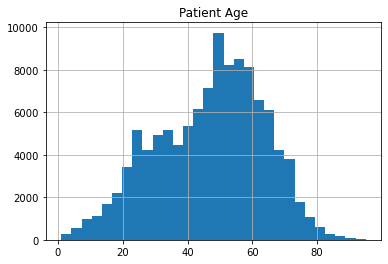

In [67]:
# Age Visualisation
xray_df = all_xray_df[all_xray_df['Patient Age']<100]
xray_df.hist('Patient Age', bins=30)
print('Max:', xray_df.max())
print('Min:', xray_df.min())

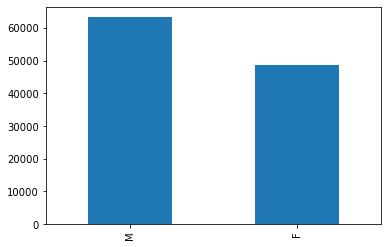

In [68]:
# Gender Visualisation
xray_df['Patient Gender'].value_counts().plot(kind='bar')

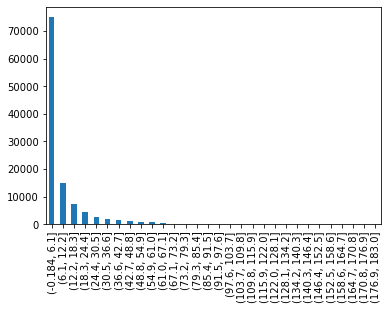

In [69]:
xray_df['Follow-up #'].value_counts(bins=30).plot(kind='bar')

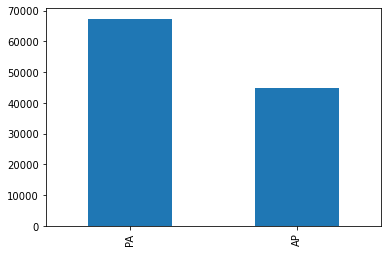

In [70]:
# Position visualisation
xray_df['View Position'].value_counts().plot(kind='bar')

In [71]:
all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    # leve out empty labels
    if len(c_label)>1:
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_df.sample(5)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


<ipython-input-71-2df1ebcfbd2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
35959,00009487_001.png,No Finding,1,9487,47,F,PA,2754,2769,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14938,00003899_002.png,No Finding,2,3899,12,M,PA,2960,2279,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
72147,00017753_023.png,Edema|Effusion|Infiltration,23,17753,63,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
51358,00012975_005.png,No Finding,5,12975,52,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63683,00015717_000.png,No Finding,0,15717,43,M,PA,2986,2731,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Total Labels: 15


[Text(0, 0.5, 'Number of images with label')]

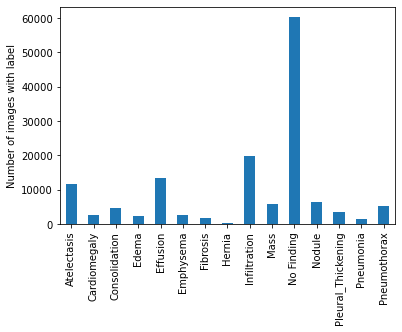

In [72]:
print('Total Labels:', len(all_labels))
ax = xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of images with label')

In [73]:
# Finding the percentage of pneumonia cases
only_pneumonia = len(xray_df[xray_df['Pneumonia'] == 1])
totalpneumonia = len(xray_df)
percentage=(only_pneumonia/totalpneumonia)*100
print('Single pneumonia percentage out of pneumonia with other diseases: {}%'.format(percentage))

Single pneumonia percentage out of pneumonia with other diseases: 1.2756012274316706%


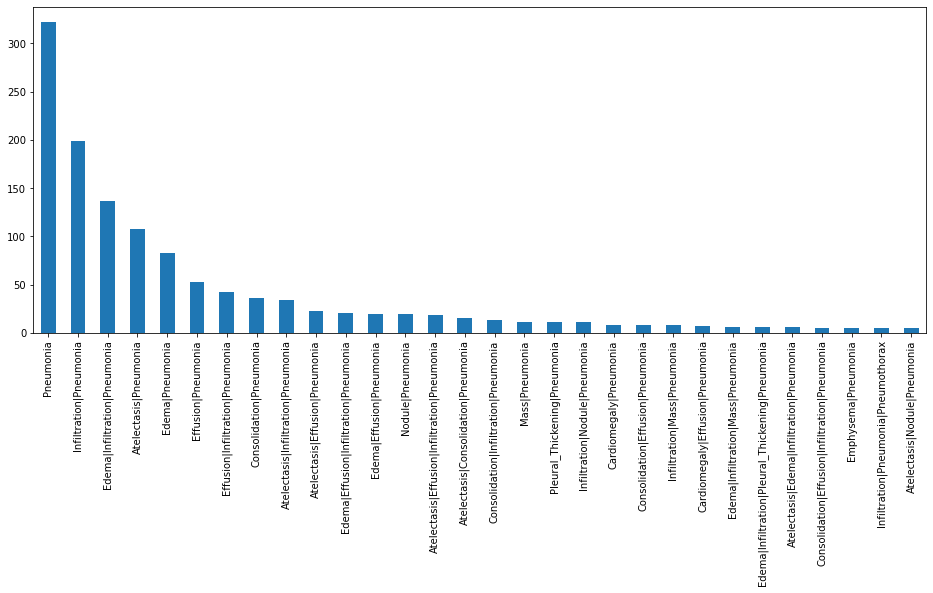

In [74]:
#30 most co-occurrences with Pneumonia
plt.figure(figsize=(16,6))
xray_df[xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Pneumonia mean age:  44.67062937062937


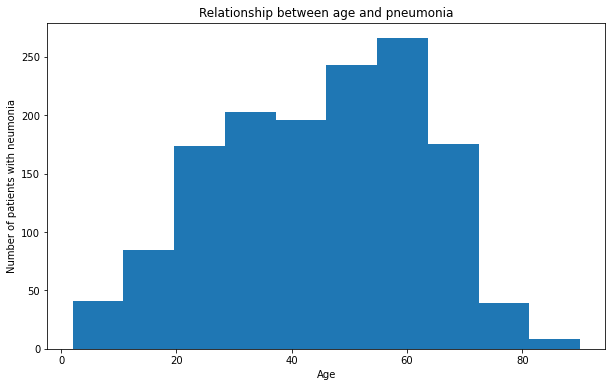

In [75]:
# Relationship between age and pneumonia
plt.figure(figsize=(10,6))
plt.hist(xray_df[xray_df.Pneumonia==1]['Patient Age'])
plt.ylabel('Number of patients with neumonia')
plt.xlabel('Age')
plt.title('Relationship between age and pneumonia')
mean_age = (xray_df[xray_df.Pneumonia == 1]['Patient Age']).mean()
print('Pneumonia mean age: ', mean_age)

Text(0.5, 1.0, 'Relationship between patient gender and pneumonia')

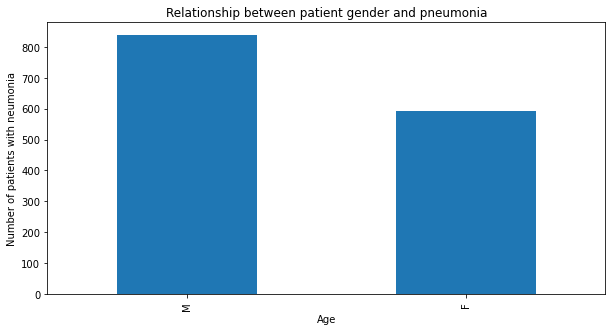

In [76]:
# Relationship between patient gender and penumonia
plt.figure(figsize=(10,5))
xray_df[xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.ylabel('Number of patients with neumonia')
plt.xlabel('Age')
plt.title('Relationship between patient gender and pneumonia')

In [77]:
# Number of diseases in each patient
xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
print(xray_df.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')


In [79]:
# Create new colum for the sum
df= xray_df.iloc[:,12:27].copy()
df.drop('No Finding', axis = 1, inplace = True)
df['Total']=df.sum(axis=1)

In [80]:
# Create new column for Age
df['Age'] = xray_df['Patient Age']

Text(0.5, 1.0, 'Histogram of total number of patients having disease')

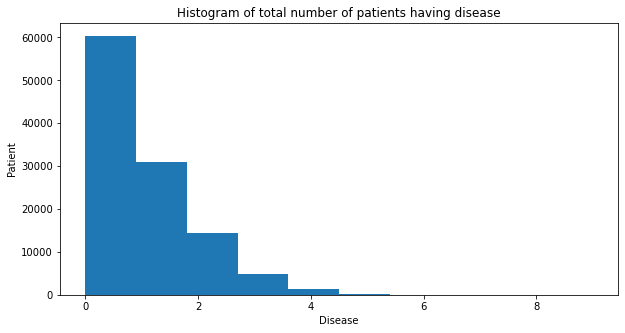

In [81]:
plt.figure(figsize=(10,5))
plt.hist(df['Total'])

plt.ylabel('Patient')
plt.xlabel('Disease')
plt.title('Histogram of total number of patients having disease')

In [82]:
# Pixel level assessment
df2 = sample_df.copy()
all_labels = np.unique(list(chain(*df2['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    # leve out empty labels
    if len(c_label)>1:
        df2[c_label] = df2['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df2.sample(5)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5070,00026946_001.png,No Finding,1,26946,026Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1154,00006058_002.png,No Finding,2,6058,039Y,M,AP,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1420,00007356_002.png,No Finding,2,7356,040Y,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1030,00005391_002.png,No Finding,2,5391,072Y,F,AP,3012,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1482,00007728_001.png,No Finding,1,7728,027Y,M,AP,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [83]:
# Create new column for pneumonia class
df2['Pneumonia_presence'] = np.where(df2['Pneumonia'] == 1, 'Pneumonia_positive', 'Pneumonia_negative')

In [84]:
df2.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_presence
1620,00008426_001.png,No Finding,1,8426,056Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Pneumonia_negative
4101,00020213_009.png,Effusion|Infiltration,9,20213,072Y,F,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative
2093,00010805_012.png,Infiltration|Pleural_Thickening,12,10805,007Y,F,AP,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Pneumonia_negative
4627,00023154_000.png,Cardiomegaly|Effusion,0,23154,035Y,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative
441,00002355_006.png,Pneumothorax,6,2355,061Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Pneumonia_negative
646,00003361_005.png,Effusion,5,3361,052Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative
1453,00007531_000.png,No Finding,0,7531,042Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Pneumonia_negative
1423,00007390_012.png,No Finding,12,7390,052Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Pneumonia_negative
397,00002054_002.png,No Finding,2,2054,027Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Pneumonia_negative
5204,00027782_002.png,Edema,2,27782,055Y,F,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative


In [85]:
# Summation of the diseases from each patient
df2.drop('No Finding', axis=1, inplace = True)
df2['Total'] = df2.iloc[:,12:27].sum(axis=1)

In [86]:
df2

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_presence,Total
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,Pneumonia_negative,4.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,2.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,1.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,0.0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,3.0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,1.0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pneumonia_negative,0.0


In [87]:
# display patient with only pneumonia
df2[(df2['Total'] == 1) & (df2['Pneumonia'] == 1)]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_presence,Total
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
3858,00019021_001.png,Pneumonia,1,19021,044Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
4033,00019865_013.png,Pneumonia,13,19865,022Y,M,PA,2786,2739,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0
4282,00021127_018.png,Pneumonia,18,21127,065Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia_positive,1.0


In [88]:
hist = df2[(df2["Pneumonia"] == 1) & (df2["Total"] == 1)]
data = []
for p in range(9):
    data.append(("pneumonia", hist.iloc[p]["path"]))

In [89]:
data

[('pneumonia', 'data\\images_004\\images\\00008470_008.png'),
 ('pneumonia', 'data\\images_006\\images\\00011702_043.png'),
 ('pneumonia', 'data\\images_006\\images\\00012158_025.png'),
 ('pneumonia', 'data\\images_006\\images\\00012667_000.png'),
 ('pneumonia', 'data\\images_006\\images\\00012733_000.png'),
 ('pneumonia', 'data\\images_007\\images\\00014201_008.png'),
 ('pneumonia', 'data\\images_008\\images\\00017714_019.png'),
 ('pneumonia', 'data\\images_009\\images\\00019021_001.png'),
 ('pneumonia', 'data\\images_009\\images\\00019865_013.png')]

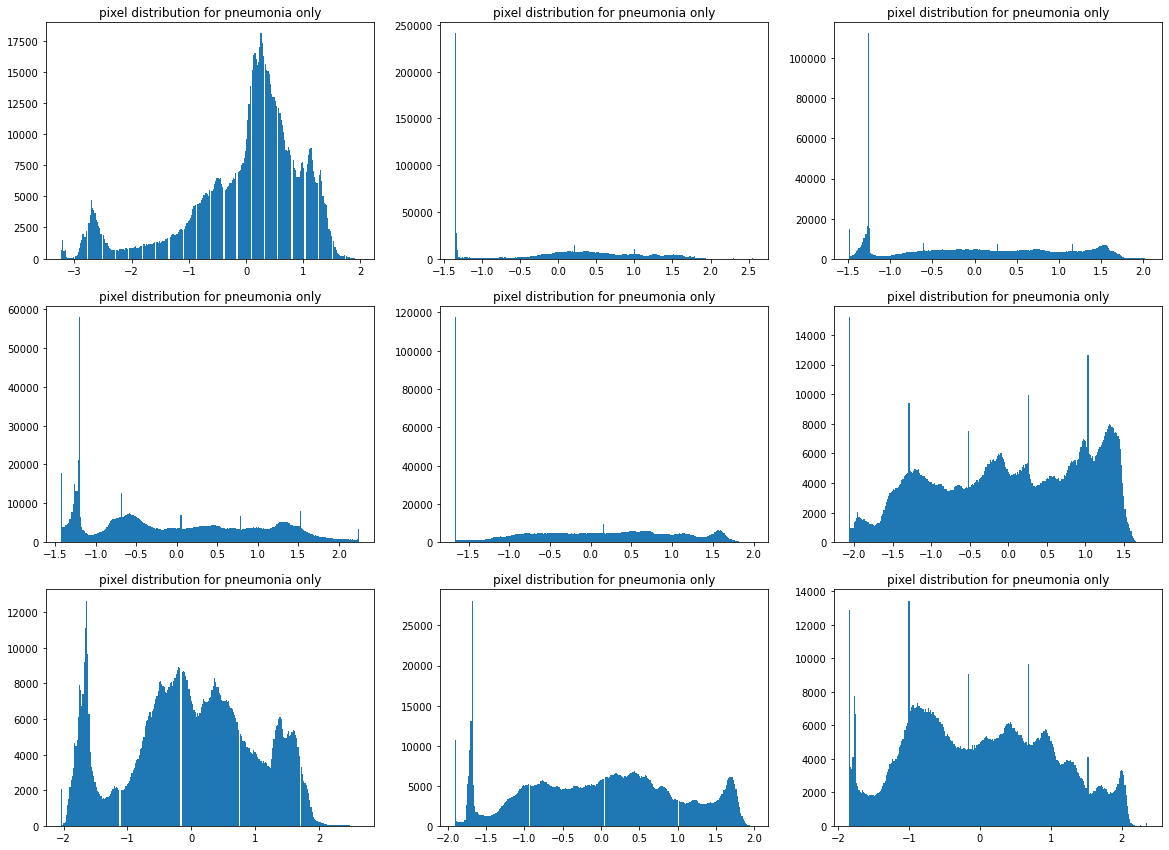

In [90]:
plt.figure(figsize=(20, 20))
j = 3
for i in range(len(data) ):
    plt.subplot(len(data) / j + 1, j, i + 1).set_title('pixel distribution for pneumonia only')
    pixel = plt.imread(data[i][1])
    plt.hist(((pixel - np.mean(pixel))/np.std(pixel)).ravel(), bins=250)
    

In [91]:
hist = df2[df2['Pneumonia_presence'] == 'Pneumonia_negative']
data = []
for i in range(9):
    data.append(('pneumonia', hist.iloc[i]['path']))

In [92]:
data

[('pneumonia', 'data\\images_001\\images\\00000013_005.png'),
 ('pneumonia', 'data\\images_001\\images\\00000013_026.png'),
 ('pneumonia', 'data\\images_001\\images\\00000017_001.png'),
 ('pneumonia', 'data\\images_001\\images\\00000030_001.png'),
 ('pneumonia', 'data\\images_001\\images\\00000032_001.png'),
 ('pneumonia', 'data\\images_001\\images\\00000040_003.png'),
 ('pneumonia', 'data\\images_001\\images\\00000042_002.png'),
 ('pneumonia', 'data\\images_001\\images\\00000057_001.png'),
 ('pneumonia', 'data\\images_001\\images\\00000061_002.png')]

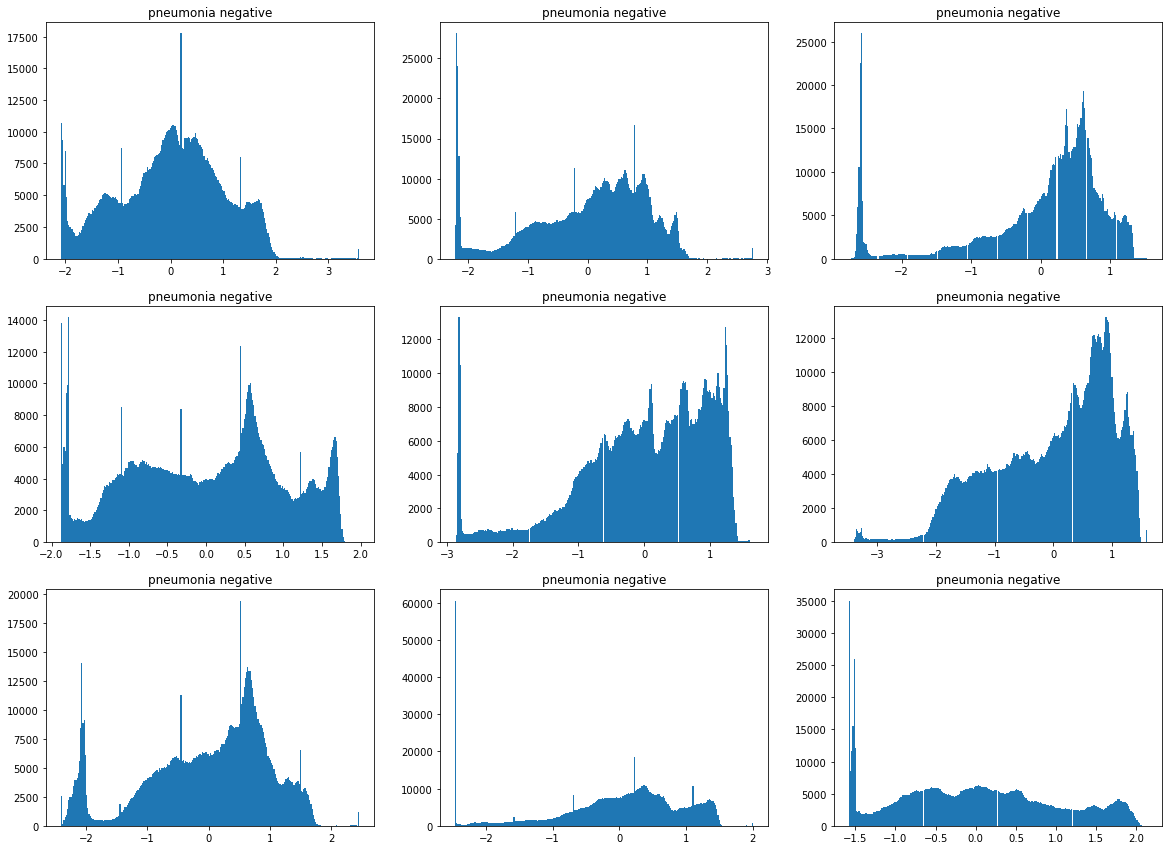

In [93]:
plt.figure(figsize=(20, 20))
j = 3
for i in range(len(data) ):
    plt.subplot(len(data) / j + 1, j, i + 1).set_title('pneumonia negative')
    pixel = plt.imread(data[i][1])
    plt.hist(((pixel - np.mean(pixel))/np.std(pixel)).ravel(), bins=250)

<ipython-input-119-db565c1ad720>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 5))


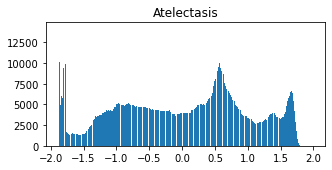

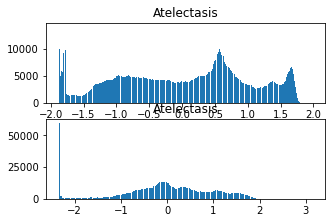

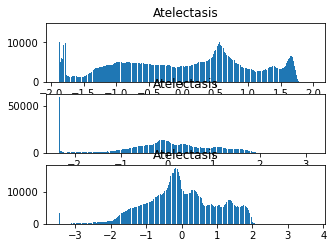

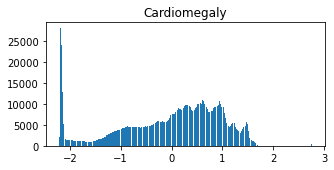

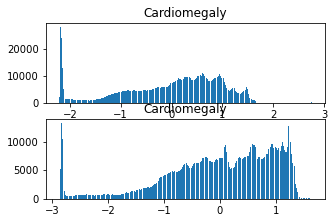

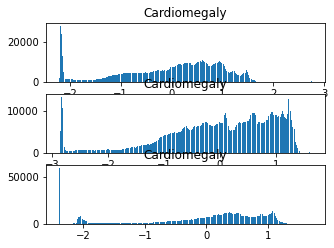

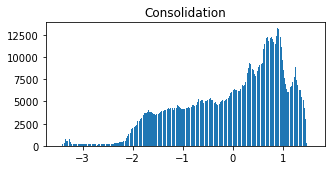

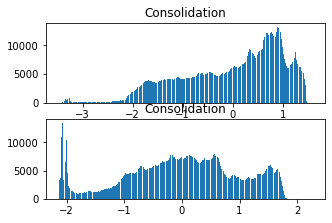

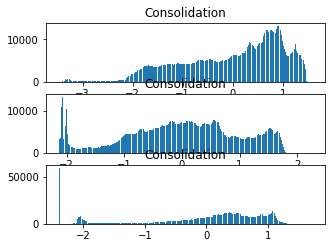

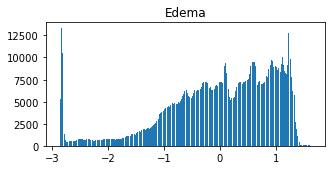

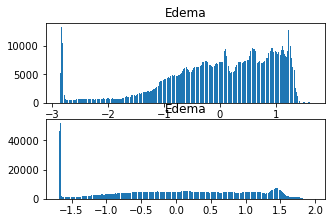

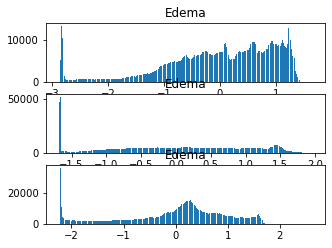

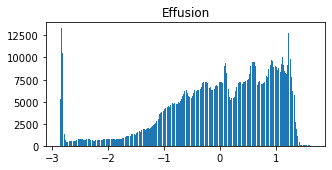

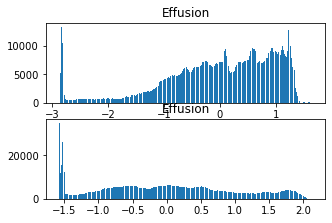

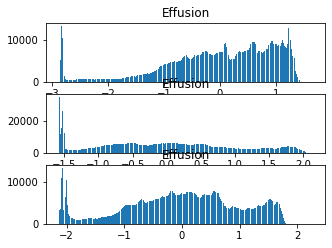

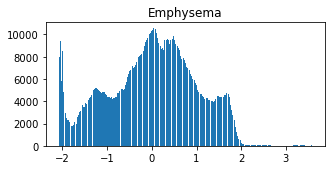

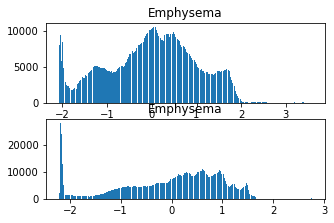

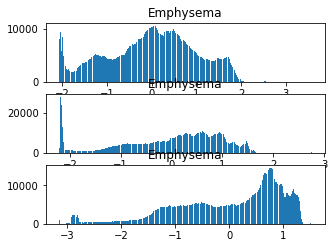

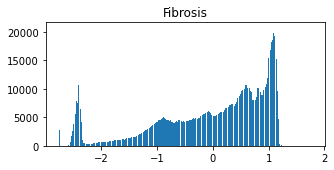

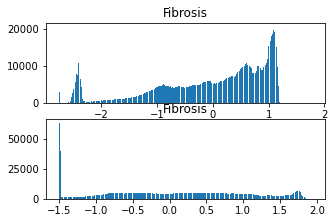

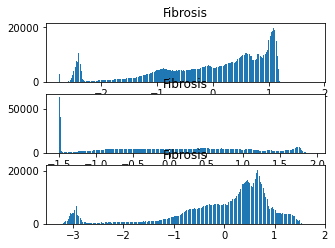

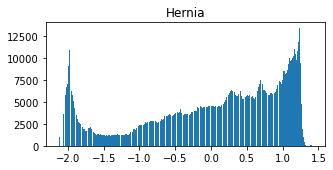

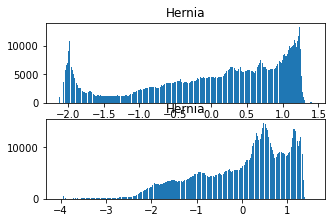

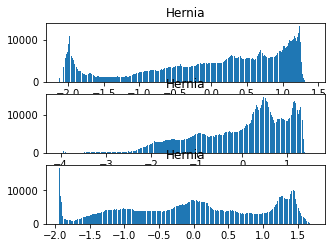

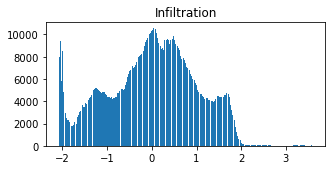

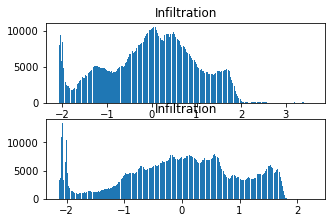

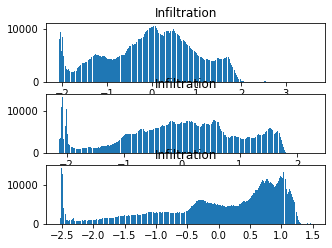

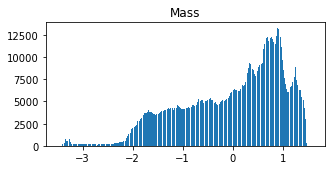

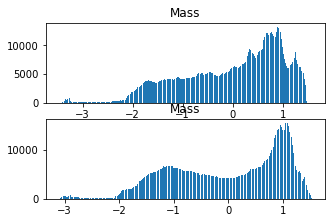

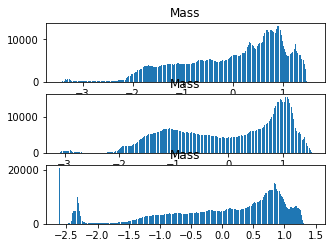

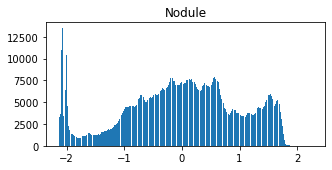

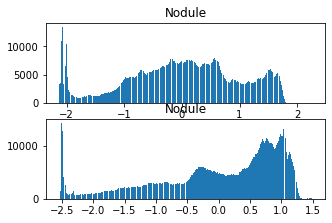

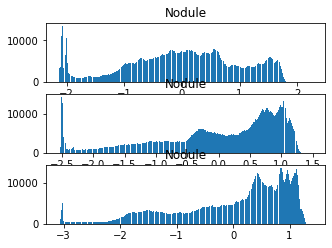

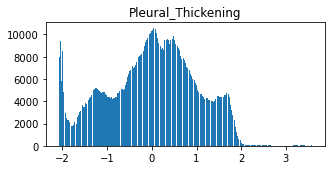

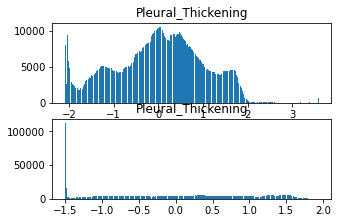

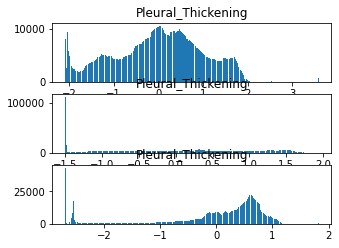

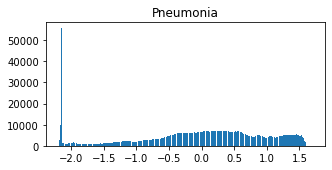

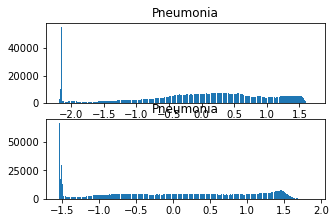

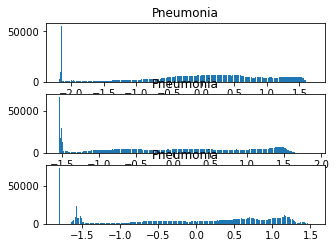

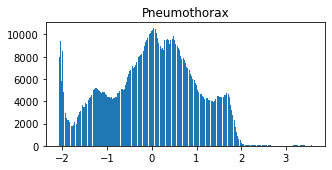

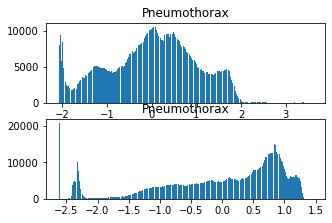

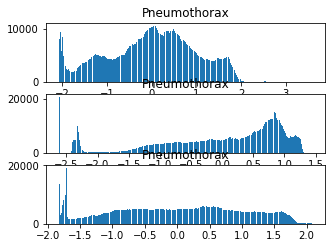

In [119]:
list = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax']
for f in list:
    hist = df2[df2[f] == 1]
    data = []
    for p in range(3):
        data.append((f, hist.iloc[p]["path"]))
        plt.figure(figsize=(5, 5))
        columns = 1
        for i in range(len(data) ):
            plt.subplot(len(data) / columns + 1, columns, i + 1).set_title(f)
            pixel = plt.imread(data[i][1])
            plt.hist(((pixel - np.mean(pixel))/np.std(pixel)).ravel(), bins=300)

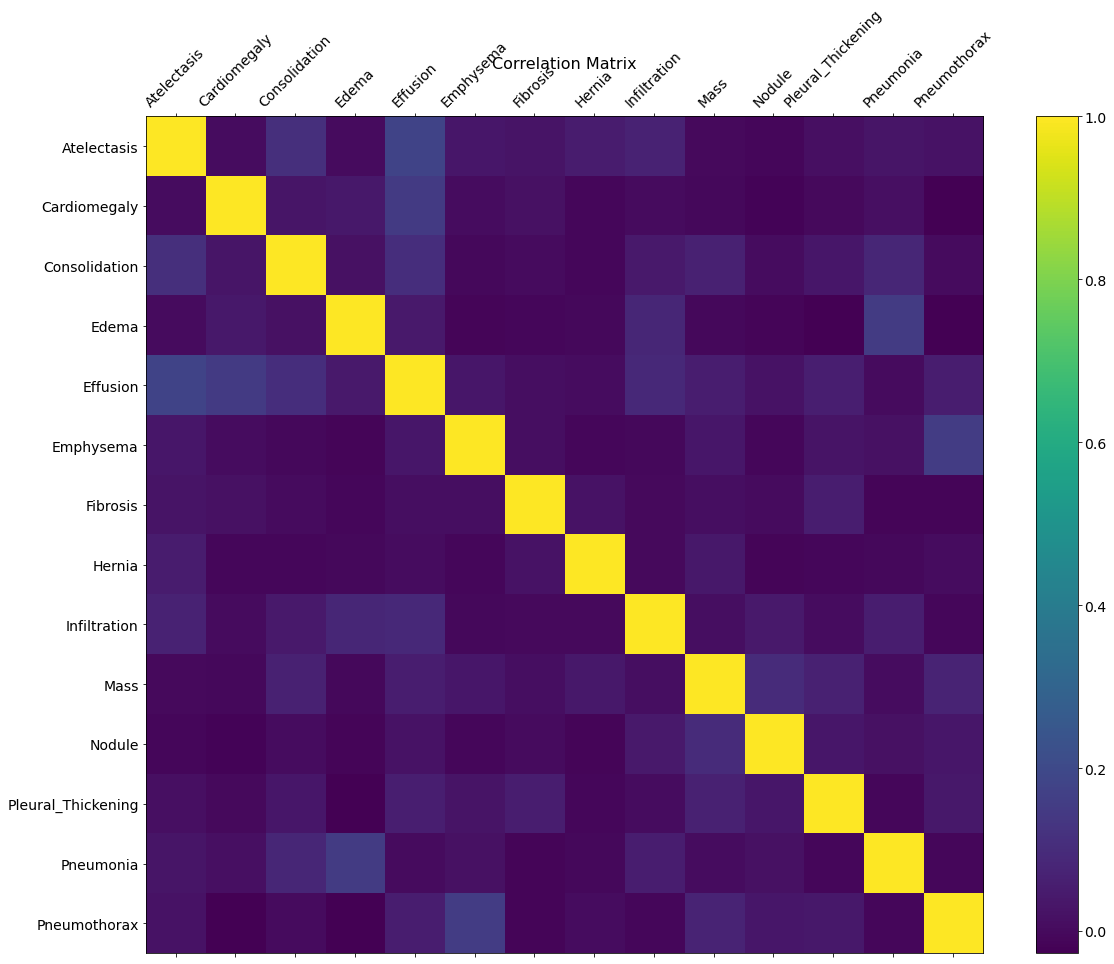

In [120]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df2.iloc[:, 12:26].corr(), fignum=f.number)
plt.xticks(range(df2.iloc[:, 12:26].shape[1]), df2.iloc[:, 12:26].columns, fontsize=14, rotation=45)
plt.yticks(range(df2.iloc[:, 12:26].shape[1]), df2.iloc[:, 12:26].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);